# A. Creating Spark Session and Loading the Data


## Step 01


### Importing pyspark and required libraries

In [1]:
# To specify the environment (using mongo spark connector)
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

# Create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql import functions as F  # Functions

# To access columns and manipulate column data types
from pyspark.sql.functions import isnan, when, count, col, sum
from pyspark.ml.feature import StringIndexer

# To vectorize the data
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# To plot graphs
import matplotlib.pyplot as plt 
%matplotlib inline

# Importing numpy
import numpy as np

# To create models of machine learning algorithm and calculate their accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

# To create confusion matrix and calculate model's precision, recall and F1 score
from pyspark.mllib.evaluation import MulticlassMetrics

### Initializing spark

In [2]:
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate() 

# If there is no existing spark context, we now create a new context with 4 cores
if (sc is None):
    sc = SparkContext(master="local[4]", appName="Rain In Australia")

# Initializing spark session    
spark = SparkSession(sparkContext=sc)\
    .builder \
    .appName("Rain In Australia") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/assign2_db.csv_data") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/assign2_db.csv_data") \
    .getOrCreate()

### Saving file location into a variable

In [3]:
# Change the file path accordingly to run
csvFile = 'weatherAUS.csv'

## Step 02

### Creating dataframe

In [4]:
# Creating a dataframe from the csv file
csvFileDF = spark.read.csv(csvFile, inferSchema=True, header=True)

### Displaying schema

In [5]:
csvFileDF.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



We see that except `date` column, all other columns are in string format.


### Displaying total number of records

In [6]:
# Number of records without filtering for null values
print("Number of records in CSV file : ",csvFileDF.count())

Number of records in CSV file :  142193


There are a total of `142,193` number of records in the file without filtering the null values.



# B. Data Cleaning and Processing

## Step 03

### Deleting columns that are not required

As per the assignment specifications, we were given a choice to remove the following columns :
`Date`, `Location`, `Evaporation`, `Sunshine`, `Cloud9am`, `Cloud3pm`, `Temp9am`, `Temp3pm`.

I'm removing all the mentioned columns because upon looking in the input file, there are many NA null values in these columns. Since we don't have all the information and the missing values are replaced with mean or maximum frequency of the column values, it doesn't makes sense to consider these columns for rain prediction for tomorrow.

In [7]:
# Dropping all columns as mentioned in specification
csvFileDF = csvFileDF.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm')

## Step 04

### Printing the number of missing data in each column

In [8]:
csvFileDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in csvFileDF.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|        0|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



We can see there are no nulls in the dataframe. However, there might be `NA` in the columns. The code for the same is below.

In [9]:
csvFileDF.select([count(when(col(c) == 'NA', c)).alias(c) for c in csvFileDF.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



As per the assignment rubric, it is mentioned that we need to write a function to achieve the same result as above. Below code snippets work for the same.

In the below cell, there's a function `countNull` which checks for the nulls in a particular column, each value is represented as boolean and it is casted as integer. This will convert `True` to `1` and `False` to `0`. Once the conversion is done, the values are casted as integer and sum is calculated. This calculated sum is then returned as the result. As a next step, we loop it through for each column, call the function and display the final result.

In [10]:
def countNull(column):
    # Check for null     
    nullOrNot = col(column).isNull()
    
    # Return sum by converting False/True into integers (0s and 1s)
    return sum(nullOrNot.cast("integer")).alias(column)

# Passing column names to the function
csvFileDF.agg(*[countNull(column) for column in csvFileDF.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|        0|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



Applying the same logic as above, the function `countNa` checks for the value `NA` instead of `NULL` and performs same operations as above.

In [11]:
def countNa(column, nan_as_null=False):
    # Check for NA
    naOrNot = col(column)=='NA'
    
    # Return sum by converting False/True into integers (0s and 1s)
    return sum(naOrNot.cast("integer")).alias(column)

# Passing column names to the function
csvFileDF.agg(*[countNa(column) for column in csvFileDF.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



We see that there are no nulls as such in the dataframe. However, there are `NA` values in almost every column. The count for the same for each column is mentioned above in tabular form.


# Step 05

### Filling the missing data with average value or maximum occurrence value


I've defined a function `displayMeanOrMax` which is based on the logic that mean for the numeric data (even though in string form) can be calculated but mean for string data doesn't exists (in other words, it'll be `None`). Below code snippet works for the same and directly prints mean value for the column if values are of numeric data type or prints maximum occurrence value for the column if values are of string data type.

In [12]:
def displayMeanOrMax(columnName):
    
    # Calculate the mean first
    result = csvFileDF.select(F.mean(col(columnName))).collect()[0][0]
    
    # If result is no mean => None
    if result is None:
        # Calculate the maximum frequency as it's data in the text form
        result = csvFileDF.filter(col(columnName)!='NA').groupBy(col(columnName)).count().orderBy('count', ascending=False).collect()[0][0]
        
        # Display the result
        print('Max of column {0} (Non-Numeric) is "{1}"'.format(c,result))
    else:
        print('Mean of column {0} (Numeric) is "{1}"'.format(c,round(result,2)))
        
# Passing column names to the function
for c in csvFileDF.columns:
    displayMeanOrMax(c)

Mean of column MinTemp (Numeric) is "12.19"
Mean of column MaxTemp (Numeric) is "23.23"
Mean of column Rainfall (Numeric) is "2.35"
Max of column WindGustDir (Non-Numeric) is "W"
Mean of column WindGustSpeed (Numeric) is "39.98"
Max of column WindDir9am (Non-Numeric) is "N"
Max of column WindDir3pm (Non-Numeric) is "SE"
Mean of column WindSpeed9am (Numeric) is "14.0"
Mean of column WindSpeed3pm (Numeric) is "18.64"
Mean of column Humidity9am (Numeric) is "68.84"
Mean of column Humidity3pm (Numeric) is "51.48"
Mean of column Pressure9am (Numeric) is "1017.65"
Mean of column Pressure3pm (Numeric) is "1015.26"
Max of column RainToday (Non-Numeric) is "No"
Max of column RainTomorrow (Non-Numeric) is "No"


Once we have determined the type of column and mean value or maximum occurrence value based on the logic above, we have to replace those values at places where `NA`is present in the columns. The function `calculateMeanOrMax` returns the result (either mean value or maximum occurrence value). The result is then replaced with `NA` in that particular column of a particular data type.

In [13]:
def calculateMeanOrMax(columnName):
    
    # Calculate the mean first
    result = csvFileDF.select(F.mean(col(columnName))).collect()[0][0]
    
    # If the result is none
    if result is None:
        # Calculate the maximum frequency
        result = csvFileDF.filter(col(columnName)!='NA').groupBy(col(columnName)).count().orderBy('count', ascending=False).collect()[0][0]
    else:
        # Round off the value to single decimal point
        result = round(csvFileDF.select(F.mean(col(columnName))).collect()[0][0], 1)
        
    return result
        
# Passing column name to the function
for column in csvFileDF.columns:
    result = calculateMeanOrMax(column)
    
    # Replacing NA with either mean or max value based on above logic
    csvFileDF = csvFileDF.withColumn(column, when(csvFileDF[column] == 'NA', result).otherwise(csvFileDF[column]))

Below code snippet is to check if all the `NA` values have been replaced or not.

In [14]:
for column in csvFileDF.columns:
    print('Number of "NA" in {0} column : {1}'.format(column, csvFileDF.filter(F.col(column) == 'NA').count()))

Number of "NA" in MinTemp column : 0
Number of "NA" in MaxTemp column : 0
Number of "NA" in Rainfall column : 0
Number of "NA" in WindGustDir column : 0
Number of "NA" in WindGustSpeed column : 0
Number of "NA" in WindDir9am column : 0
Number of "NA" in WindDir3pm column : 0
Number of "NA" in WindSpeed9am column : 0
Number of "NA" in WindSpeed3pm column : 0
Number of "NA" in Humidity9am column : 0
Number of "NA" in Humidity3pm column : 0
Number of "NA" in Pressure9am column : 0
Number of "NA" in Pressure3pm column : 0
Number of "NA" in RainToday column : 0
Number of "NA" in RainTomorrow column : 0


# Step 06

### Data transformation

As mentioned in the specification document, the below code firstly uses the function `calculateMeanOrMax` and based on the logic explained earlier, we get it's type as a string(maximum occurrence value) or float(mean value). So, based on the type of the result, I've casted the column as double for numeric column or applied stringIndexer for string column. Also, once string index is run of columns with non-numeric data, original columns are removed.

Here, I've considered `RainToday` column even though in the specification, it is not mentioned as a string column. Excluding this column, we get lesser accuracy (although difference is in decimals) and hence, I've included it in the string indexer and eventually vectorized and considered as a feature.

In [15]:
# For numeric type columns
for column in csvFileDF.columns:
    result = calculateMeanOrMax(column)
    if type(result) == float:
        csvFileDF = csvFileDF.withColumn(column, col(column).cast("double"))

In [16]:
# For string type columns
for column in csvFileDF.columns:
    result = calculateMeanOrMax(column)
    if type(result) == str:
        columnName = column + 'Index'
        indexer = StringIndexer(inputCol=column, outputCol=columnName)
        csvFileDF = indexer.fit(csvFileDF).transform(csvFileDF)
        csvFileDF = csvFileDF.drop(column)

In [17]:
csvFileDF.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- WindGustDirIndex: double (nullable = false)
 |-- WindDir9amIndex: double (nullable = false)
 |-- WindDir3pmIndex: double (nullable = false)
 |-- RainTodayIndex: double (nullable = false)
 |-- RainTomorrowIndex: double (nullable = false)



We see that all the columns have been transformed into double data type.

# Step 07

### Create the feature vector and divide the dataset

Here, we vectorize the dataframe. All the columns except for `RainTomorrowIndex` have been considered as `features`. The `features` are the columns based on which we can predict the rainfall for tomorrow. Vectorizing the dataframe columns results into list of values as `features` and that is why we don't need all other columns. Hence, all the columns can be dropped except for `RainTomorrowIndex` column which is our target and `features` column.

In [18]:
# Initialize vector object
vectorAssemblerObject = VectorAssembler(inputCols = csvFileDF.columns[0:-1], outputCol="features")   

# Transform the dataset
csvFileVectorDF = vectorAssemblerObject.transform(csvFileDF)

# Remove undesired columns
csvFileDF = csvFileVectorDF.drop('MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'WindGustDirIndex',
 'WindDir9amIndex',
 'WindDir3pmIndex',
 'RainTodayIndex')

# Displaying the new dataframe formed
csvFileDF.show(3, False)

+-----------------+----------------------------------------------------------------------+
|RainTomorrowIndex|features                                                              |
+-----------------+----------------------------------------------------------------------+
|0.0              |[13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,0.0,6.0,7.0,0.0]|
|0.0              |[7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,9.0,9.0,3.0,0.0]  |
|0.0              |[12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,6.0,6.0,3.0,0.0]|
+-----------------+----------------------------------------------------------------------+
only showing top 3 rows



Now that the dataset has been vectorized and unwanted columns are removed, we can split the data into training and testing datapoints. Below is the code for the same. Seed value has been set to 123 and can be changed based on the requirement.

In [19]:
(trainingData, testData) = csvFileDF.randomSplit([0.7, 0.3], seed = 123)

# B. Applying Machine Learning Algorithms

## Step 08

### Applying machine learning algorithms and comparing their accuracy

As an initial step, we create empty lists to store algorithm type and its accuracy. We calculate the accuracy of the different machine learning algorithms such as `Decision Tree Algorithm`, `Random Forest Algorithm`, `Logistic Regression Algorithm` and `GBT Classifier Algorithm`.

In [20]:
# To store algorithm type
algorithm = []

# To store accuracy of respective algorithm type
accuracy = []

In [21]:
# Decision Tree Algorithm

# Initializing decision tree model object
decisionTree = DecisionTreeClassifier(labelCol="RainTomorrowIndex", featuresCol="features")

# Training the data
decisionTreeModel = decisionTree.fit(trainingData)

# Transforming using the test data
decisionTreePredictions = decisionTreeModel.transform(testData)

# Displaying the prediction dataframe
decisionTreePredictions.select("prediction", "RainTomorrowIndex", "probability").show(10)

# Initializing the evaluator
decisionTreeEvaluator = MulticlassClassificationEvaluator(\
labelCol="RainTomorrowIndex", predictionCol="prediction",\
metricName="accuracy")

# To calculate accuracy
decisionTreeAccuracy = decisionTreeEvaluator.evaluate(decisionTreePredictions)

# Displaying the accuracy and test error
print("Test Error = %g " % (1.0 - decisionTreeAccuracy))

print("Accuracy = %g " % (decisionTreeAccuracy))

# Storing algorithm type and its accuracy in the lists
algorithm.append('Decision Tree')

accuracy.append(decisionTreeAccuracy)

+----------+-----------------+--------------------+
|prediction|RainTomorrowIndex|         probability|
+----------+-----------------+--------------------+
|       0.0|              0.0|[0.64608739837398...|
|       0.0|              0.0|[0.89153324893886...|
|       0.0|              0.0|[0.89153324893886...|
|       0.0|              0.0|[0.64608739837398...|
|       0.0|              0.0|[0.89153324893886...|
|       0.0|              0.0|[0.64608739837398...|
|       0.0|              0.0|[0.64608739837398...|
|       0.0|              0.0|[0.64608739837398...|
|       0.0|              0.0|[0.69920152544392...|
|       1.0|              0.0|[0.14692787177203...|
+----------+-----------------+--------------------+
only showing top 10 rows

Test Error = 0.164865 
Accuracy = 0.835135 


In [22]:
# Random Forest Algorithm

# Initializing random forest model object
randomForest = RandomForestClassifier(labelCol="RainTomorrowIndex", featuresCol="features", numTrees=10)

# Training the data
randomForestModel = randomForest.fit(trainingData)

# Transforming using the test data
randomForestPredictions = randomForestModel.transform(testData)

# Displaying the prediction data
randomForestPredictions.select("prediction", "RainTomorrowIndex", "probability").show(10)

# Initializing the evaluator
randomForestEvaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex", predictionCol="prediction", metricName="accuracy")

# To calculate accuracy
randomForestAccuracy = randomForestEvaluator.evaluate(randomForestPredictions)

# Displaying the accuracy and test error
print("Test Error = %g" % (1.0 - randomForestAccuracy))

print("Accuracy = %g" % (randomForestAccuracy))

# Storing the algorithm type and its accuracy in the list
algorithm.append('Random Forest')

accuracy.append(randomForestAccuracy)

+----------+-----------------+--------------------+
|prediction|RainTomorrowIndex|         probability|
+----------+-----------------+--------------------+
|       0.0|              0.0|[0.73625954684666...|
|       0.0|              0.0|[0.86565708426746...|
|       0.0|              0.0|[0.86565708426746...|
|       0.0|              0.0|[0.53610909032819...|
|       0.0|              0.0|[0.86565708426746...|
|       0.0|              0.0|[0.54904961306284...|
|       0.0|              0.0|[0.59877257537248...|
|       0.0|              0.0|[0.59877257537248...|
|       0.0|              0.0|[0.84033289570718...|
|       1.0|              0.0|[0.33663779484535...|
+----------+-----------------+--------------------+
only showing top 10 rows

Test Error = 0.163807
Accuracy = 0.836193


In [23]:
# Logistic Regression Algorithm

# Initializing logistic regression model object
logisticRegression = LogisticRegression(featuresCol = 'features', labelCol = 'RainTomorrowIndex', maxIter=10)

# Training the data
logisticRegressionModel = logisticRegression.fit(trainingData)

# Transforming using the test data
logisticRegressionPredictions = logisticRegressionModel.transform(testData)

# Displaying the predictions dataframe 
logisticRegressionPredictions.select('prediction', 'RainTomorrowIndex', 'probability').show(10)

# Initializing the evaluator
logisticRegressionEvaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy
logisticRegressionAccuracy = logisticRegressionEvaluator.evaluate(logisticRegressionPredictions)

# Displaying the accuracy and test error
print("Test Error = %g " % (1.0 - logisticRegressionAccuracy))

print("Accuracy = %g " % (logisticRegressionAccuracy))

# Storing the algorithm type and its accuracy
algorithm.append('Logistic Regression')

accuracy.append(logisticRegressionAccuracy)

+----------+-----------------+--------------------+
|prediction|RainTomorrowIndex|         probability|
+----------+-----------------+--------------------+
|       0.0|              0.0|[0.71489262051085...|
|       0.0|              0.0|[0.75421241864582...|
|       0.0|              0.0|[0.76868088283889...|
|       0.0|              0.0|[0.65070952180140...|
|       0.0|              0.0|[0.71118011460962...|
|       0.0|              0.0|[0.66693991363888...|
|       0.0|              0.0|[0.69491039072215...|
|       0.0|              0.0|[0.70414966934782...|
|       0.0|              0.0|[0.73146341668892...|
|       0.0|              0.0|[0.64771152389897...|
+----------+-----------------+--------------------+
only showing top 10 rows

Test Error = 0.186325 
Accuracy = 0.813675 


In [24]:
# GBT Clasifier Algorithm

# Initializing gbt clasifier mdoel object
gbtClassifier = GBTClassifier(labelCol="RainTomorrowIndex", featuresCol="features", maxIter=10)

# Training the data
gbtClassifierModel = gbtClassifier.fit(trainingData)

# Transforming using the test data
gbtClassifierPredictions = gbtClassifierModel.transform(testData)

# Displaying the predictions dataframe
gbtClassifierPredictions.select('prediction', 'RainTomorrowIndex', 'probability').show(10)

# Initializing the evaluator
gbtClassifierEvaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
gbtClassifierAccuracy = gbtClassifierEvaluator.evaluate(gbtClassifierPredictions)

# Displaying the accuracy and test error
print("Test Error = %g " % (1.0 - gbtClassifierAccuracy))

print("Accuracy = %g " % (gbtClassifierAccuracy))

# Storing the algorithm type and its accuracy
algorithm.append('GBT Classifier')

accuracy.append(gbtClassifierAccuracy)

+----------+-----------------+--------------------+
|prediction|RainTomorrowIndex|         probability|
+----------+-----------------+--------------------+
|       0.0|              0.0|[0.66658948114436...|
|       0.0|              0.0|[0.77607571373069...|
|       0.0|              0.0|[0.76170117707270...|
|       0.0|              0.0|[0.66658948114436...|
|       0.0|              0.0|[0.66658948114436...|
|       0.0|              0.0|[0.66658948114436...|
|       0.0|              0.0|[0.66658948114436...|
|       0.0|              0.0|[0.66658948114436...|
|       0.0|              0.0|[0.65577299769673...|
|       1.0|              0.0|[0.26310003895202...|
+----------+-----------------+--------------------+
only showing top 10 rows

Test Error = 0.160234 
Accuracy = 0.839766 


Now that we've calculated the accuracies of different models, we can plot the graphs with the algorithm type on x-axis and their respective accuracy on y-axis.

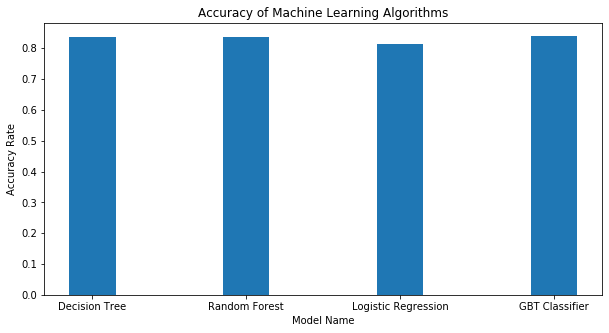

In [25]:
#  Setting figure size
plt.figure(figsize=(10,5))

# Plotting the graph
plt.bar(algorithm, accuracy, width = .3)

# Setting labels and titles
plt.xlabel('Model Name')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy of Machine Learning Algorithms')

# Displaying the graph
plt.show()

Since the comparison of accuracy of different models is difficult using bar graph as suggested in the specification document, below code snippet plots line graph for better visualization.

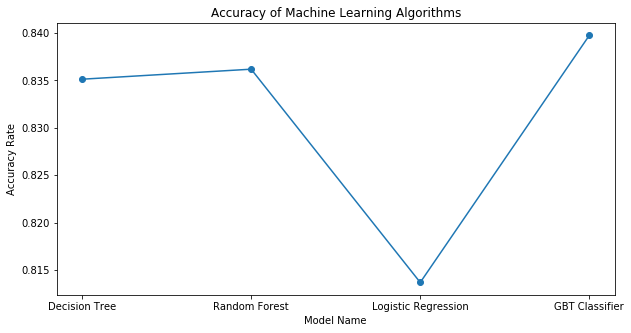

In [26]:
# Seting figure size
plt.figure(figsize=(10,5))

# Plotting the graph
plt.plot(algorithm, accuracy, 'o-')

# Setting labels and title
plt.xlabel('Model Name')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy of Machine Learning Algorithms')

# Displaying the graph
plt.show()

Please note I've set maxIter or maximum number of trees as 10. From the above line graph, we can compare the models and their accuracy. We see that for the given dataset, `Decision Tree Model` gives the accuracy of about `83.3%`, `Random Forest Model` gives accuracy of `83.6%`, `Logistic Regression Model` gives the accuracy of about `81.3%` and `GBT Classifier Model` provides accuracy of `83.9%`. We also notice that `Random Forest Model` provides slightly better accuracy rate compared to `Decision Tree Model`, `Logistic Regression Model` provides the least accuracy rate and `GBT Classifier Model` provides the highest accuracy among all models. 


## Step 09

### Calculating the confusion matrix and finding precision, recall and F1 score

Here, I've defined a method which takes confusion matrix as input and calculates precision, recall and F1 score and returns them as output.

In [27]:
def calculateParameters(confusionMatrix):
    
    # Setting the elements of confusion matrix
    trueNegative = confusionMatrix[0][0]
    falsePositive = confusionMatrix[0][1]
    falseNegative = confusionMatrix[1][0]
    truePositive = confusionMatrix[1][1]
    
    # Calculating precision, recall and F1 score
    precision = truePositive/(truePositive + falsePositive)
    recall = truePositive/(truePositive + falseNegative)
    f1Score = (2*(precision * recall)/(precision + recall))
    
    # Returning the calculated values
    return precision, recall, f1Score

In [28]:
# Confusion Matrix for Decision Tree

# Extracting only prediction and RainTomorrowIndex and then converting the dataframe into rdd
decisionTreePredictionAndLabels = decisionTreePredictions.select(['prediction', 'RainTomorrowIndex']).rdd.map(tuple)

# Intializing metrics object
decisionTreeMetrics = MulticlassMetrics(decisionTreePredictionAndLabels)

# Create confusion matrix for the model
decisionTreeConfusionMatrix = decisionTreeMetrics.confusionMatrix().toArray()

# Displaying the confusion matrix
print('Confusion Matrix for decision tree : ')
print(decisionTreeConfusionMatrix)

Confusion Matrix for decision tree : 
[[31889.  1115.]
 [ 5899.  3641.]]


In [29]:
# Calculate precision, recall and F1 score of the model
decisionTreePrecision, decisionTreeRecall, decisionTreeF1Score = calculateParameters(decisionTreeConfusionMatrix)

# Displaying the above calculated parameters
print('Precision value through formula using confusion matrix :', decisionTreePrecision)
print('Recall value through formula using confusion matrix :', decisionTreeRecall)
print('F1 score value through formula using confusion matrix :', decisionTreeF1Score)

Precision value through formula using confusion matrix : 0.7655592935239697
Recall value through formula using confusion matrix : 0.3816561844863732
F1 score value through formula using confusion matrix : 0.5093732512590934


In [30]:
# Confusion Matrix for Random Forest

# Extracting only prediction and RainTomorrowIndex and then converting the dataframe into rdd
randomForestPredictionAndLabels = randomForestPredictions.select(['prediction', 'RainTomorrowIndex']).rdd.map(tuple)

# Initializing metrics object
randomForestMetrics = MulticlassMetrics(randomForestPredictionAndLabels)

# Create confusion matrix for this model
randomForestConfusionMatrix = randomForestMetrics.confusionMatrix().toArray()

# Displaying the confusion matrix
print('Confusion Matrix for random forest : ')
print(randomForestConfusionMatrix)

Confusion Matrix for random forest : 
[[31817.  1187.]
 [ 5782.  3758.]]


In [31]:
# Calculate precision, recall and F1 score of this model 
randomForestPrecision, randomForestRecall, randomForestF1Score = calculateParameters(randomForestConfusionMatrix)

# Displaying above calculated parameters
print('Precision value through formula using confusion matrix :', randomForestPrecision)
print('Recall value through formula using confusion matrix :', randomForestRecall)
print('F1 score value through formula using confusion matrix :', randomForestF1Score)

Precision value through formula using confusion matrix : 0.7599595551061679
Recall value through formula using confusion matrix : 0.3939203354297694
F1 score value through formula using confusion matrix : 0.5188816016568865


In [32]:
# Confusion Matrix for Logistic Regression

# Extracting only prediction and RainTomorrowIndex and then converting the dataframe into rdd
logisticRegressionPredictionAndLabels = logisticRegressionPredictions.select(['prediction', 'RainTomorrowIndex']).rdd.map(tuple)

# Intializing metrics object
logisticRegressionMetrics = MulticlassMetrics(logisticRegressionPredictionAndLabels)

# Creating confusion matrix for this model
logisticRegressionConfusionMatrix = logisticRegressionMetrics.confusionMatrix().toArray()

# Displaying the confusion matrix
print('Confusion Matrix for logistic regression : ')
print(logisticRegressionConfusionMatrix)

Confusion Matrix for logistic regression : 
[[30712.  2292.]
 [ 5635.  3905.]]


In [33]:
# Calculate precision, recall and F1 score for this model
logisticRegressionPrecision, logisticRegressionRecall, logisticRegressionF1Score = calculateParameters(logisticRegressionConfusionMatrix)

# Displaying the above calculated parameters
print('Precision value through formula using confusion matrix :', logisticRegressionPrecision)
print('Recall value through formula using confusion matrix :', logisticRegressionRecall)
print('F1 score value through formula using confusion matrix :', logisticRegressionF1Score)

Precision value through formula using confusion matrix : 0.6301436178796191
Recall value through formula using confusion matrix : 0.40932914046121593
F1 score value through formula using confusion matrix : 0.4962826459935185


In [34]:
# Confusion Matrix for GBT Classifier

# Extracting only prediction and RainTomorrowIndex and then converting the dataframe into rdd
gbtClassifierPredictionAndLabels = gbtClassifierPredictions.select(['prediction', 'RainTomorrowIndex']).rdd.map(tuple)

# Initializing metrics object
gbtClassifierMetrics = MulticlassMetrics(gbtClassifierPredictionAndLabels)

# Creating confusion matrix for this model
gbtClassifierConfusionMatrix = gbtClassifierMetrics.confusionMatrix().toArray()

# Displaying the confusion matrix
print('Confusion Matrix for gbt classifier : ')
print(gbtClassifierConfusionMatrix)

Confusion Matrix for gbt classifier : 
[[31231.  1773.]
 [ 5044.  4496.]]


In [35]:
# Calculate precision, recall and F1 score for this model
gbtClassifierPrecision, gbtClassifierRecall, gbtClassifierF1Score = calculateParameters(gbtClassifierConfusionMatrix)

# Displaying the above calculated parameters
print('Precision value through formula using confusion matrix :', gbtClassifierPrecision)
print('Recall value through formula using confusion matrix :', gbtClassifierRecall)
print('F1 score value through formula using confusion matrix :', gbtClassifierF1Score)

Precision value through formula using confusion matrix : 0.7171797734885946
Recall value through formula using confusion matrix : 0.4712788259958071
F1 score value through formula using confusion matrix : 0.5687899297868303


There are a number of ways to improve the accuracy of the model. Below are some of the approaches :

- By adding up more known/complete data instead of taking subset of huge dataset. Doing so will allow the data to represent itself instead of manipulating it to achieve desired results.

- It is always good to have as much training data as possible. Having more of training data with some variance is beneficial for model training to get higher accuracy for the test/new data.

- The missing values or outliers reduce the accuracy and hence, it would be better to have as less of such values as possible. So, it is important to treat missing and outlier values. Missing data can be handled in various ways such as using prediction algorithm or replacing missing data with mean, median or mode to impute the misisng data. Similarly, we can delete or treat outliers separately.

- Transforming the data into features helps to spot correlation and variance in the dataset, thereby giving improved accuracy. For instance, if a data set has 1st variable in meter, 2nd in centi-meter and 3rd in kilo-meter, in such case, before applying any algorithm, we must normalize these variable in same scale. Similarly, there are concepts such as data normalization, data discretization, removal of skewness of variable, converting huge numeric data into log scale etc that fall under the category of feature transforming.

- Creating a new feature from the existing variable also influences accuracy. It helps to unleash the hidden relationship of a data set. For example, if we want to predict the number of transactions in a store based on transaction dates, we may notice that the transaction dates may not have direct correlation with number of transaction. However, if we look at the day of a week, it may have a higher correlation. In this case, the information about day of a week is hidden. We need to extract it to make the model better.

- Applying right kind of machine learning algorithm also helps to enhance accuracy rate of the prediction. Some algorithms are better suited to a particular type of data sets than others. Hence, we should apply all relevant models and check the performance. For instance, for data which is continuous in nature, linear regression can be applied or might be best suited rather than logistic regression.

- Selecting correct subset of the attributes as features to predict the target value. This falls under the category of feature selection.

- We can tune the algorithm by varying the parameters of the model described. Parameters such as maxIter, max number of trees etc influence the accuracy. These parameters majorly influence the outcome of learning process. The objective of parameter tuning is to find the optimum value for each parameter to improve the accuracy of the model. To tune these parameters, one must have a good understanding of their meaning and individual impact on the model that is being used. For example: In random forest, we have various parameters like max_features, number_trees, random_state, oob_score and others. Intuitive optimization of these parameter values will result in better and more accurate models. Similarly, we have maxIter paramter in logistic regression and gbt classifier models. It is important to find a suitable number such that the accuracy is in the desired range. A model can be discarded if it gives low accuracy. However, high accuracy need not always mean that the model is performing efficiently. Let's say we have a model that predicts if a patient has cancer or not and has the accuracy of 97%. Even though the model has high accuracy, there are chances of 3% of it going wrong i.e. wrongly predicting if the person has cancer or not (concepts of false positive and false negative). In a situation of life and death, small percentage of fail rate can also impact the model's credibility or usability.

# References

- Monash tutorials and lecture demo files

- https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

- https://stackoverflow.com/questions/52299443/pyspark-calculate-number-of-null-values-in-each-dataframe-column

- https://forums.wikitechy.com/question/count-number-of-non-nan-entries-in-each-column-of-spark-dataframe-with-pyspark/

- https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

- https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html

- https://en.wikipedia.org/wiki/Confusion_matrix

- https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

- https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/